### Plots for the paper

In [55]:
################## IMPORT LIBRARIES ##################
import sys
import importlib
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import glob
import os
import torch
from os.path import join as pjoin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io.wavfile as wavfile
from scipy import stats
import pyloudnorm as pyln

In [56]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation_simple 

importlib.reload(evaluation_simple)
importlib.reload(hlp)

<module 'helpers' from '/home/ubuntu/guestxr2/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/helpers.py'>

In [57]:
# ----- Load and prepare raw MUSHRA data -----

file_path = "../sounds/mushra_lufs_results2.csv"

df = pd.read_csv(file_path, sep=";", on_bad_lines='skip') 

df=df.iloc[0:,3:].T.reset_index()
df = df.drop(columns=["index"])

df.rename(columns={df.columns[0]: "audio_file"}, inplace=True)
df.rename(columns={df.columns[1]: "trial"}, inplace=True)
for i in range(2, len(df.columns)):
    df.rename(columns={df.columns[i]: f"user{i-2}"}, inplace=True)

df["trial"]=df["trial"].fillna(method='ffill', limit=6)

# Exclude the trial with the audio example 5 rating, bc it was invalid
df = df[~df["trial"].isin(["Audio Example 5 rating"])] #lufs


In [58]:
# ---- Add columns with relevant information for further processing ----

# short condition names based on the audio file names
df["condition"]=np.nan
df.loc[df["audio_file"].str.contains("target"),"condition"]="target"
df.loc[(df["audio_file"].str.contains("stft") & df["audio_file"].str.contains("prediction")),"condition"]="stft+wav"
df.loc[(df["audio_file"].str.contains("logmel") & df["audio_file"].str.contains("prediction")),"condition"]="logmel+wav"
df.loc[(df["audio_file"].str.contains("anecho") & df["audio_file"].str.contains("prediction")),"condition"]="anecho+fins"
df.loc[(df["audio_file"].str.contains("dfnet") & df["audio_file"].str.contains("prediction")),"condition"]="dfnet+fins"
df.loc[(df["audio_file"].str.contains("wpe") & df["audio_file"].str.contains("prediction")),"condition"]="wpe+fins"
df.loc[df["audio_file"].str.contains("content"),"condition"]="content"

# type of transformation in the trial (dry2rev or rev2dry)
df["revdiff"]=np.nan
df.loc[df["trial"].str.contains("9"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("5"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("4"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("6"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("8"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("1"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("3"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("7"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("10"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("2"),"revdiff"]="dry2rev"

df.head(10)

,audio_file,trial,user0,user1,user2,user3,user4,user5,user6,user7,...,user9,user10,user11,user12,user13,user14,user15,user16,condition,revdiff
0,b12_i0_target.wav,Audio Example 1 rating,100,100,100,100,92,80,100,75,...,100,43,97,100,100,100,100,96,target,dry2rev
1,b12_i0_content.wav,Audio Example 1 rating,18,0,50,22,87,0,0,22,...,0,9,0,0,0,19,0,45,content,dry2rev
2,10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b12_i0_prediction.wav,Audio Example 1 rating,61,29,50,92,96,100,0,51,...,91,71,82,50,86,32,100,90,stft+wav,dry2rev
3,20-05-2024--22-48_c_wunet_logmel+wave_0.8_0.2_b12_i0_prediction.wav,Audio Example 1 rating,19,0,33,40,95,100,0,100,...,62,71,75,28,41,64,65,0,logmel+wav,dry2rev
4,anecho+fins_b12_i0_prediction.wav,Audio Example 1 rating,81,100,100,40,94,80,88,100,...,70,84,62,59,93,19,100,62,anecho+fins,dry2rev
5,dfnet+fins_b12_i0_prediction.wav,Audio Example 1 rating,81,37,81,86,80,40,86,27,...,51,76,40,74,59,78,90,73,dfnet+fins,dry2rev
6,wpe+fins_b12_i0_prediction.wav,Audio Example 1 rating,19,52,20,64,74,20,22,60,...,18,42,13,59,65,0,81,21,wpe+fins,dry2rev
7,b10_i2_target.wav,Audio Example 2 rating,100,100,100,80,83,100,100,19,...,100,78,99,100,100,99,100,100,target,dry2rev
8,b10_i2_content.wav,Audio Example 2 rating,20,0,20,0,75,40,0,0,...,0,34,0,0,0,0,0,4,content,dry2rev
9,10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b10_i2_prediction.wav,Audio Example 2 rating,63,72,51,80,79,60,21,22,...,89,60,20,73,79,7,16,38,stft+wav,dry2rev


In [59]:
# ----- Exclude participants who rated the hidden reference below 90 in more than 15% of the trials -----

hidref_df=df[df["audio_file"].str.contains("target")]

# Select only user columns (assuming they start with "user")
hidref_user_cols = [col for col in hidref_df.columns if col.startswith("user")]
# Convert user columns to numeric
hidref_df[hidref_user_cols]=hidref_df[hidref_user_cols].apply(pd.to_numeric, errors='coerce')

# Count how many times each user rated below 90
below_90 = hidref_df[hidref_user_cols] < 90
low_rating_counts = below_90.sum()

# Find users who rated < 90 more than once 
users_to_exclude = low_rating_counts[low_rating_counts > 1].index
users_to_keep = low_rating_counts[low_rating_counts <= 1].index

# Drop those users from the original dataframe 
df= df.drop(columns=users_to_exclude)

print("Excluded users:", list(users_to_exclude))

print("Remaining users:", list(users_to_keep))

Excluded users: ['user3', 'user4', 'user5', 'user7', 'user10']
Remaining users: ['user0', 'user1', 'user2', 'user6', 'user8', 'user9', 'user11', 'user12', 'user13', 'user14', 'user15', 'user16']


/tmp/ipykernel_1172583/2927373045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hidref_df[hidref_user_cols]=hidref_df[hidref_user_cols].apply(pd.to_numeric, errors='coerce')


In [60]:
# ----- Check if no ratings are missing anywhere -----
# (the count should be the same for all conditions)
df.groupby(["condition"]).count()

,audio_file,trial,user0,user1,user2,user6,user8,user9,user11,user12,user13,user14,user15,user16,revdiff
condition,,,,,,,,,,,,,,,
anecho+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
content,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
dfnet+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
logmel+wav,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
stft+wav,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
target,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
wpe+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [61]:
# ---------------- Reshape MUSHRA data for convenience ----------------

pivot_df = df.melt(id_vars=['condition',"trial","revdiff"], value_vars=users_to_keep,
                   var_name='user', value_name='score')

pivot_df["score"]= pd.to_numeric(pivot_df["score"])

# Create a df with mean participant scores per each played audio in MUSHRA teast
mean_sample_scores=pivot_df.groupby(["trial","condition"])["score"].mean().reset_index()

# create an index column to correspond with the sample number (bc later the df with metrics has this convention)
mean_sample_scores["idx"]=mean_sample_scores["trial"].str.extract(r'(\d+)').astype(int)

display(mean_sample_scores)

,trial,condition,score,idx
0,Audio Example 1 rating,anecho+fins,74.750000,1
1,Audio Example 1 rating,content,11.000000,1
2,Audio Example 1 rating,dfnet+fins,67.833333,1
3,Audio Example 1 rating,logmel+wav,34.166667,1
4,Audio Example 1 rating,stft+wav,57.750000,1
...,...,...,...,...
58,Audio Example 9 rating,dfnet+fins,62.000000,9
59,Audio Example 9 rating,logmel+wav,21.250000,9
60,Audio Example 9 rating,stft+wav,54.916667,9
61,Audio Example 9 rating,target,99.833333,9


/tmp/ipykernel_1172583/3088731875.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.15, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")


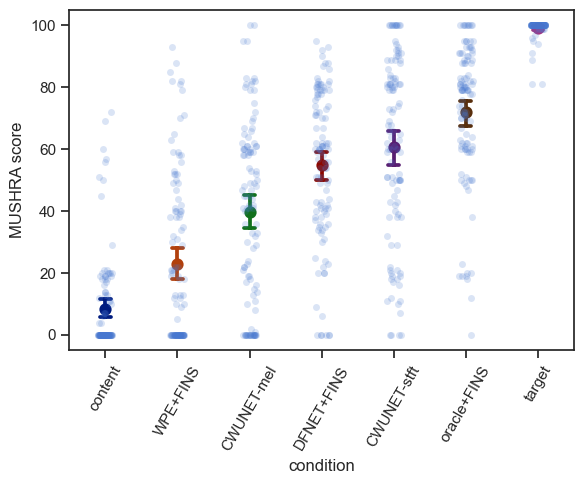

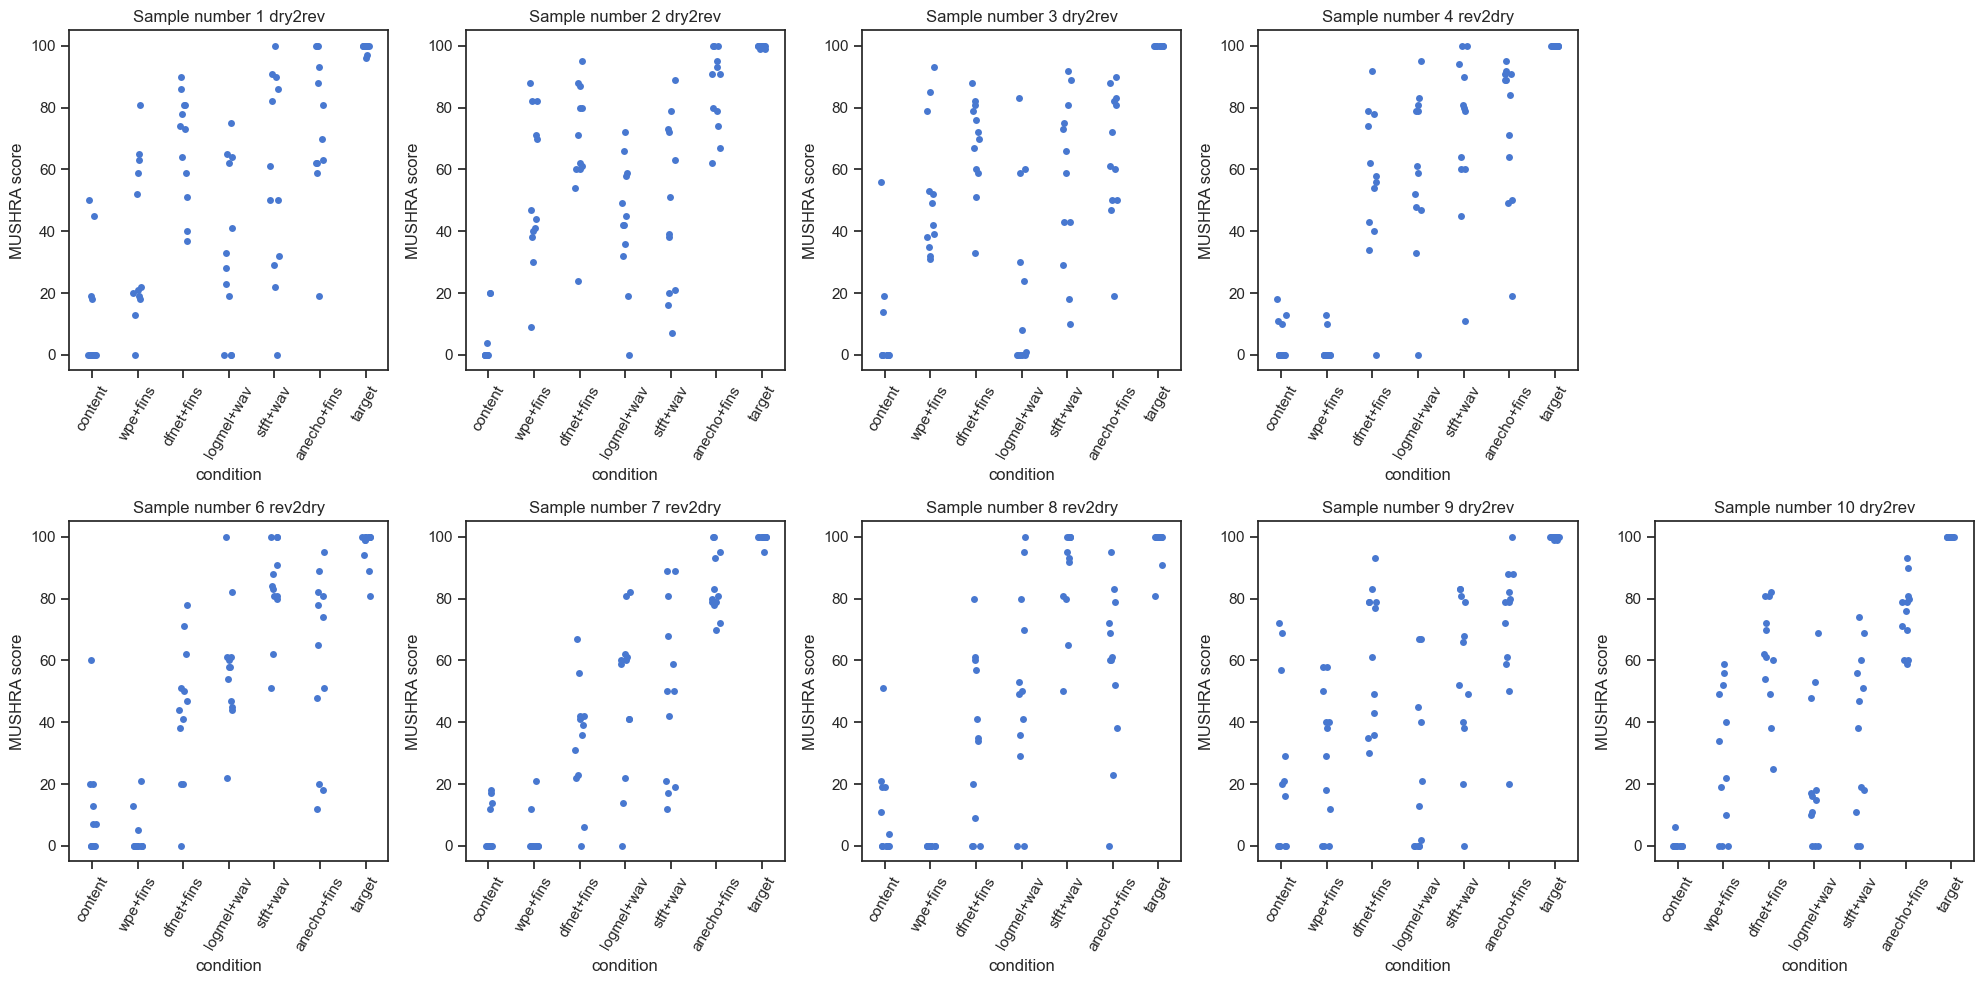

In [71]:
# ---------------- Plot MUSHRA results ----------------

sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "wpe+fins", "logmel+wav", "dfnet+fins", "stft+wav",  "anecho+fins", "target"]
myxticks=["content",  "WPE+FINS", "CWUNET-mel", "DFNET+FINS",  "CWUNET-stft", "oracle+FINS", "target"]
plt.figure(figsize=(6,5))
sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.15, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")
sns.stripplot(data=pivot_df, x="condition", y="score", order=condition_order,alpha=0.2)
plt.xticks(np.arange(7),myxticks,rotation=60)
plt.ylabel("MUSHRA score")
plt.title(f"")
plt.tight_layout()
plt.savefig('mushraA.pdf', format='pdf')
plt.show()


sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "wpe+fins", "dfnet+fins",  "logmel+wav", "stft+wav",  "anecho+fins", "target"]

plt.figure(figsize=(20,10))
# setting font sizeto 30
valid_examples=[1,2,3,4,6,7,8,9,10]
for i in valid_examples:
    one_example=pivot_df[pivot_df["trial"]==f"Audio Example {i} rating"].reset_index()
    r=one_example["revdiff"][0]
    plt.subplot(2,5,i)
    sns.stripplot(data=one_example, x="condition", y="score", order=condition_order)
    plt.ylabel("MUSHRA score")
    plt.xticks(rotation=60)
    plt.title(f"Sample number {i} " + r)
plt.tight_layout()
plt.show()

In [63]:
# Define the condition pairs to compare
pairs = [
    ("target", "anecho+fins"),
    ("target", "stft+wav"),
    ("target", "dfnet+fins"),
    ("anecho+fins", "stft+wav"),
    ("anecho+fins", "dfnet+fins"),
    ("anecho+fins", "logmel+wav"),
    ("anecho+fins", "wpe+fins"),
    ("stft+wav", "dfnet+fins"),
    ("dfnet+fins","logmel+wav"),
]

# Run Wilcoxon tests
for cond1, cond2 in pairs:
    scores1 = pivot_df.loc[pivot_df["condition"] == cond1, "score"]
    scores2 = pivot_df.loc[pivot_df["condition"] == cond2, "score"]
    stat_will, p_will = stats.wilcoxon(scores1, scores2)
    stat_t, p_t = stats.ttest_ind(scores1, scores2)
    print(f"{cond1} vs {cond2} (Wilcoxon test): statistic={stat_will:.3f}, p-value={p_will:.1e}")
    print(f"{cond1} vs {cond2} (t-test): statistic={stat_t:.3f}, p-value={p_t:.1e}")
    print("----------------------")


target vs anecho+fins (Wilcoxon test): statistic=4.000, p-value=4.3e-18
target vs anecho+fins (t-test): statistic=12.583, p-value=1.5e-27
----------------------
target vs stft+wav (Wilcoxon test): statistic=37.000, p-value=1.7e-17
target vs stft+wav (t-test): statistic=13.486, p-value=2.1e-30
----------------------
target vs dfnet+fins (Wilcoxon test): statistic=0.000, p-value=1.9e-19
target vs dfnet+fins (t-test): statistic=18.752, p-value=4.7e-47
----------------------
anecho+fins vs stft+wav (Wilcoxon test): statistic=1986.500, p-value=5.0e-03
anecho+fins vs stft+wav (t-test): statistic=3.138, p-value=1.9e-03
----------------------
anecho+fins vs dfnet+fins (Wilcoxon test): statistic=912.500, p-value=6.3e-09
anecho+fins vs dfnet+fins (t-test): statistic=5.349, p-value=2.3e-07
----------------------
anecho+fins vs logmel+wav (Wilcoxon test): statistic=695.500, p-value=9.2e-12
anecho+fins vs logmel+wav (t-test): statistic=9.111, p-value=6.0e-17
----------------------
anecho+fins vs wp

In [64]:
# ----------------- ANALYZE AUDIO SAMPLES USED IN MUSHRA -----------------
# i.e. check rms levels and loudness, compute metrics for all samples


filenames=[] 
levels=[]
lufs = []
sample_in_test_nr = []
condition = [] 
eval_dict_list=[]


# ----------------- Before the loop, initialize evaluation object (to compute metrics) -----------------
# load default config
config=hlp.load_config(pjoin("/home/ubuntu/guestxr2/home/ubuntu/joanna/reverb-match-cond-u-net/config/basic.yaml"))
# initialize evaluator
myeval = evaluation_simple.Evaluator(config)
# get speech reference for non-intrusive metrics:
speechref = hlp.torch_load_mono("/home/ubuntu/guestxr2/home/ubuntu/joanna/reverb-match-cond-u-net/sounds/speech_VCTK_4_sentences.wav",48000)[:,:4*48000].unsqueeze(1)


for i in range(0,10):
    # Loop over 10 mushra samples (=comparisons)...

    if i!=4:  # skip sample 5, because it is invalid in the MUSHRA test

        for filename in glob.glob(os.path.join(f"../sounds/Mushra-LUFS/Sample{i+1}/", '*.wav')):
            # Loop over each audio file...

            fs, x = wavfile.read(filename)
            x = x.astype(np.float32)

            # append file name of the sample:
            filenames.append(filename)

            # append rms level of the sample:
            levels.append(20*np.log10(np.sqrt(np.mean(x**2))))

            # append loudness:
            meter = pyln.Meter(48000) 
            loudness = meter.integrated_loudness(x)
            lufs.append(loudness)
            sample_in_test_nr.append(i+1)

            # append condition and prepare signals for metric analysis:
            if "target" in filename: condition.append("target"); sTarget = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "content" in filename: condition.append("content"); sContent = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "anecho.wav" in filename: condition.append("anecho"); sAnecho = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "anecho+fins" in filename: condition.append("anecho+fins"); sPredict_anechofins = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "stft" in filename: condition.append("stft+wav"); sPredict_stft = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "logmel" in filename: condition.append("logmel+wav"); sPredict_logmel = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "dfnet" in filename: condition.append("dfnet+fins"); sPredict_dfnet = torch.tensor(x).unsqueeze(0).unsqueeze(0)
            if "wpe" in filename: condition.append("wpe+fins"); sPredict_wpe = torch.tensor(x).unsqueeze(0).unsqueeze(0)


    # For each Mushra sample, compute metrics (to compare with the results of the MUSHRA test)
    eval_dict_list.append(myeval.metrics4batch(i+1,"content","target:content",sTarget,sContent,sAnecho,nmref=speechref))
    eval_dict_list.append(myeval.metrics4batch(i+1,"anecho+fins","target:prediction",sTarget,sPredict_anechofins,sAnecho,nmref=speechref))
    eval_dict_list.append(myeval.metrics4batch(i+1,"stft+wav","target:prediction",sTarget,sPredict_stft,sAnecho,nmref=speechref))
    eval_dict_list.append(myeval.metrics4batch(i+1,"logmel+wav","target:prediction",sTarget,sPredict_logmel,sAnecho,nmref=speechref))
    eval_dict_list.append(myeval.metrics4batch(i+1,"dfnet+fins","target:prediction",sTarget,sPredict_dfnet,sAnecho,nmref=speechref))
    eval_dict_list.append(myeval.metrics4batch(i+1,"wpe+fins","target:prediction",sTarget,sPredict_wpe,sAnecho,nmref=speechref))


samples_stats=pd.DataFrame([])
samples_stats["filename"]=filenames
samples_stats["level"]=levels
samples_stats["lufs"]=lufs
samples_stats["condition"]=condition
samples_stats["sample_nr"]=sample_in_test_nr

display(samples_stats.head(10))

samples_metrics=pd.DataFrame(eval_dict_list)
display(samples_metrics.head(10))

2025-07-09 12:29:59 | INFO     | DF | Loading model settings of DeepFilterNet3
2025-07-09 12:29:59 | INFO     | DF | Using DeepFilterNet3 model at /home/ubuntu/.cache/DeepFilterNet/DeepFilterNet3
2025-07-09 12:29:59 | INFO     | DF | Initializing model `deepfilternet3`
2025-07-09 12:29:59 | INFO     | DF | Found checkpoint /home/ubuntu/.cache/DeepFilterNet/DeepFilterNet3/checkpoints/model_120.ckpt.best with epoch 120
2025-07-09 12:29:59 | INFO     | DF | Running on device cuda:0
2025-07-09 12:29:59 | INFO     | DF | Model loaded
Preparing to evaluate 1000 test datapoints


,filename,level,lufs,condition,sample_nr
0,../sounds/Mushra-LUFS/Sample1/20-05-2024--22-48_c_wunet_logmel+wave_0.8_0.2_b12_i0_prediction.wav,-24.701388,-22.0,logmel+wav,1
1,../sounds/Mushra-LUFS/Sample1/10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b12_i0_prediction.wav,-24.615653,-22.0,stft+wav,1
2,../sounds/Mushra-LUFS/Sample1/anecho+fins_b12_i0_prediction.wav,-24.761643,-22.0,anecho+fins,1
3,../sounds/Mushra-LUFS/Sample1/dfnet+fins_b12_i0_prediction.wav,-24.832659,-22.0,dfnet+fins,1
4,../sounds/Mushra-LUFS/Sample1/b12_i0_content.wav,-24.789140,-22.0,content,1
5,../sounds/Mushra-LUFS/Sample1/wpe+fins_b12_i0_prediction.wav,-24.797921,-22.0,wpe+fins,1
6,../sounds/Mushra-LUFS/Sample1/b12_i0_anecho.wav,-24.715855,-22.0,anecho,1
7,../sounds/Mushra-LUFS/Sample1/b12_i0_target.wav,-24.712453,-22.0,target,1
8,../sounds/Mushra-LUFS/Sample2/b10_i2_anecho.wav,-24.475498,-22.0,anecho,2
9,../sounds/Mushra-LUFS/Sample2/dfnet+fins_b10_i2_prediction.wav,-24.299879,-22.0,dfnet+fins,2


,label,idx,compared,1L_multi-stft-mag,1L_stft-mag,1L_multi-wave,1L_wave,1L_logmel,1L_multi-mel,1S_sisdr,...,2S_pesq,2S_stoi,3D_pesq,3D_stoi,3D_sisdr,3D_mos_nidiff,3D_pesq_nidiff,3D_stoi_nidiff,3D_sisdr_nidiff,3D_srmr_nidiff
0,content,1,target:content,0.350004,0.342633,0.023111,0.015497,4.905216,0.256631,4.746119,...,2.337710,0.878146,0.450459,0.014866,0.184904,0.655904,0.039271,0.254231,2.262381,0.107265
1,anecho+fins,1,target:prediction,0.446777,0.443045,0.028866,0.028395,1.249368,0.182075,-0.282804,...,2.421150,0.864194,0.192820,0.022312,7.354036,0.557731,0.024778,0.419872,1.115131,1.017446
2,stft+wav,1,target:prediction,0.277769,0.267531,0.017590,0.023156,0.638395,0.106547,6.875797,...,2.822573,0.910397,0.163204,0.008383,1.245687,0.338042,0.001845,0.742615,4.891679,0.161304
3,logmel+wav,1,target:prediction,0.302680,0.287233,0.018909,0.017493,0.666000,0.104607,5.161086,...,2.860271,0.889144,0.149356,0.008941,1.486755,0.315957,0.006047,0.723857,2.668800,0.139976
4,dfnet+fins,1,target:prediction,0.481681,0.472356,0.031259,0.024917,1.705678,0.209602,-1.728031,...,2.461674,0.837593,0.105838,0.059196,8.663841,0.258756,0.085946,0.335777,2.690032,1.198111
5,wpe+fins,1,target:prediction,0.528363,0.518468,0.030805,0.023583,1.979031,0.220842,-2.604174,...,2.106384,0.734942,0.087879,0.172902,9.110851,0.734461,0.081099,0.483963,6.260909,1.458183
6,content,2,target:content,0.333086,0.326537,0.042278,0.048416,4.241834,0.326190,4.062393,...,1.660922,0.904324,0.506664,0.000714,2.046928,0.030533,0.163650,0.674842,6.072150,7.764815
7,anecho+fins,2,target:prediction,0.333932,0.329019,0.034818,0.044445,0.928249,0.154067,2.201600,...,1.893970,0.903082,0.107276,0.005160,2.323844,0.003946,0.022293,0.078954,1.251404,0.796066
8,stft+wav,2,target:prediction,0.273420,0.262274,0.023539,0.030714,0.905381,0.144004,5.560259,...,2.014313,0.914968,0.264263,0.006420,1.372811,0.019968,0.026524,0.358929,3.313050,1.684805
9,logmel+wav,2,target:prediction,0.298177,0.279817,0.024941,0.033495,0.742713,0.117254,4.431380,...,2.064896,0.918911,0.165072,0.005703,0.016574,0.001608,0.026207,0.120458,2.445145,1.330302


In [ ]:
# ---------------- CORRELATE MUSHRA SCORES WITH METRICS ----------------

# Choose metrics to use
chosen_metrics_list=['1L_multi-mel', '1L_multi-wave','1L_emb_euc', '2L_multi-stft', '2L_mcd' , '2S_fwsnr', '3D_pesq', '3D_stoi', '3D_mos_nidiff', '3D_pesq_nidiff', '3D_stoi_nidiff', '3D_sisdr_nidiff', '3D_srmr_nidiff']
samples_metrics_sel=samples_metrics[['label','idx', *chosen_metrics_list]]
samples_metrics_sel.rename(columns={'label': 'condition'}, inplace=True)
# Merge the mean participant scores with the metrics
merged_df = pd.merge(samples_metrics_sel, mean_sample_scores, on=['idx', 'condition'], how='outer', sort=True)

# Remove the column with target (because its nan for metrics)
merged_df = merged_df[~merged_df["condition"].isin(["target"])]

# For each metric, compute the correlation with the mean participant scores
for metric in chosen_metrics_list:
    # sns.set_theme(style="ticks", palette="muted")
    # condition_order = ["content", "wpe+fins", "logmel+wav", "dfnet+fins", "stft+wav",  "anecho+fins", "target"]
    # myxticks=["content",  "WPE+FINS", "CWUNET-mel", "DFNET+FINS",  "CWUNET-stft", "oracle+FINS", "target"]
    # plt.figure(figsize=(3,3))
    # sns.pointplot(data=merged_df, x="condition", y=metric, capsize=0.15, errorbar=('ci', 95),order=condition_order, linestyles="")
    # sns.stripplot(data=merged_df, x="condition", y=metric, order=condition_order,alpha=0.2)
    # plt.xticks(np.arange(7),myxticks,rotation=60)
    # plt.ylabel("MUSHRA score")
    # plt.title(f"")
    # plt.tight_layout()
    # plt.savefig('mushraA.pdf', format='pdf')
    # plt.show()
    corr = merged_df[metric].corr(merged_df["score"])
    print(metric + " " + str(corr))

1L_multi-mel -0.36246164408420317
1L_multi-wave -0.2215022203989173
1L_emb_euc -0.2624406793058932
2L_multi-stft -0.33444510097747376
2L_mcd -0.19809792452472433
2S_fwsnr 0.21040995639339585
3D_pesq -0.44933198658792584
3D_stoi -0.23004059544096814
3D_mos_nidiff -0.18719624924782013
3D_pesq_nidiff -0.5202309936335267
3D_stoi_nidiff -0.6396157732393447
3D_sisdr_nidiff -0.423602508224603
3D_srmr_nidiff -0.15887476417530325


/tmp/ipykernel_1172583/4118027042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_metrics_sel.rename(columns={'label': 'condition'}, inplace=True)


In [66]:
# # ----------------- EQUALIZE LOUDNESS OF AUDIO SAMPLES  -----------------

# filenames=[]
# levels=[]
# lufs = []
# lufs_new = []
# levels_new=[]

# for i in range(0,10):
#     for filename in glob.glob(os.path.join(f"../sounds/Mushra-LUFS/Sample{i+1}/", '*.wav')):
#         fs, x = wavfile.read(filename)
#         x = x.astype(np.float32)
#         filenames.append(filename)
#         levels.append(20*np.log10(np.sqrt(np.mean(x**2))))

#         # set RMS:
#         # x_new=hlp.np_set_rms_level(x,-20)

#         # set LOUDNESS:
#         meter = pyln.Meter(48000) 
#         loudness = meter.integrated_loudness(x)
#         lufs.append(loudness)

#         # loudness normalize audio to -22 dB LUFS
#         x_new = pyln.normalize.loudness(x, loudness, -22.0)
#         lufs_new.append(meter.integrated_loudness(x_new))

#         levels_new.append(20*np.log10(np.sqrt(np.mean(x_new**2))))

#         # Overwrite the WAV file
#         wavfile.write(filename, 48000, x_new.astype(np.float32))